# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

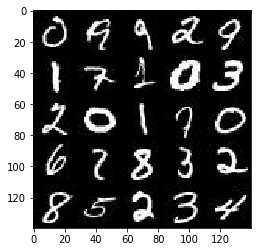

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

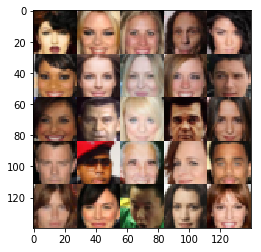

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
alpha = 0.2

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        #print(x1.get_shape().as_list())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        #print(x2.get_shape().as_list())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #print (x3.get_shape().as_list())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        ## 16x16x64 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        #print (x4.get_shape().as_list())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        ## 16x16x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)       
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    images_fake = generator(input_z, out_channel_dim, True)
        
    d_model_real, d_logits_real = discriminator(input_real, False)    
    d_model_fake, d_logits_fake = discriminator(images_fake, True)
    
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
print_every = 10
show_every = 200
no_display_images = 20
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()  
    if data_image_mode == 'RGB':
        out_channel_dim = 3        
    else:
        out_channel_dim = 1

    input_real, input_z, l_r = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)            
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    
    steps = 0
    losses = []    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2;

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:                    
                    show_generator_output(sess, no_display_images, input_z, out_channel_dim, data_image_mode)
                    
        show_generator_output(sess, no_display_images, input_z, out_channel_dim, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.9591... Generator Loss: 0.5033
Epoch 0/2... Discriminator Loss: 0.4738... Generator Loss: 1.2594
Epoch 0/2... Discriminator Loss: 0.5243... Generator Loss: 1.0001
Epoch 0/2... Discriminator Loss: 0.9672... Generator Loss: 5.6885
Epoch 0/2... Discriminator Loss: 0.6373... Generator Loss: 1.5137
Epoch 0/2... Discriminator Loss: 0.3415... Generator Loss: 8.9333
Epoch 0/2... Discriminator Loss: 1.2664... Generator Loss: 0.3533
Epoch 0/2... Discriminator Loss: 4.2616... Generator Loss: 8.7610
Epoch 0/2... Discriminator Loss: 3.4801... Generator Loss: 0.0856
Epoch 0/2... Discriminator Loss: 0.5080... Generator Loss: 3.3419
Epoch 0/2... Discriminator Loss: 1.0686... Generator Loss: 0.4874
Epoch 0/2... Discriminator Loss: 5.3656... Generator Loss: 0.0075
Epoch 0/2... Discriminator Loss: 0.3777... Generator Loss: 1.9976
Epoch 0/2... Discriminator Loss: 2.0275... Generator Loss: 3.8925
Epoch 0/2... Discriminator Loss: 1.4038... Generator Loss: 2.1811
Epoch 0/2.

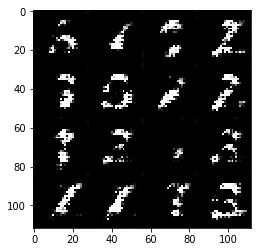

Epoch 0/2... Discriminator Loss: 0.6526... Generator Loss: 1.0029
Epoch 0/2... Discriminator Loss: 0.5099... Generator Loss: 2.1765
Epoch 0/2... Discriminator Loss: 0.9913... Generator Loss: 0.6794
Epoch 0/2... Discriminator Loss: 0.8332... Generator Loss: 0.9846
Epoch 0/2... Discriminator Loss: 0.6686... Generator Loss: 1.4621
Epoch 0/2... Discriminator Loss: 1.5551... Generator Loss: 1.4472
Epoch 0/2... Discriminator Loss: 0.8688... Generator Loss: 1.1739
Epoch 0/2... Discriminator Loss: 0.9176... Generator Loss: 1.1342
Epoch 0/2... Discriminator Loss: 1.1750... Generator Loss: 0.8078
Epoch 0/2... Discriminator Loss: 1.2292... Generator Loss: 0.4850
Epoch 0/2... Discriminator Loss: 0.9735... Generator Loss: 1.5565
Epoch 0/2... Discriminator Loss: 1.0810... Generator Loss: 1.8414
Epoch 0/2... Discriminator Loss: 1.2139... Generator Loss: 0.7698
Epoch 0/2... Discriminator Loss: 1.5096... Generator Loss: 0.9298
Epoch 0/2... Discriminator Loss: 0.7562... Generator Loss: 1.1280
Epoch 0/2.

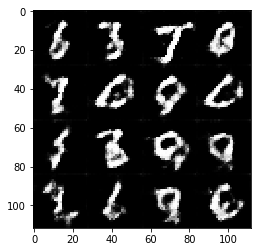

Epoch 0/2... Discriminator Loss: 1.0171... Generator Loss: 0.7758
Epoch 0/2... Discriminator Loss: 2.5234... Generator Loss: 2.8680
Epoch 0/2... Discriminator Loss: 1.2689... Generator Loss: 0.5499
Epoch 0/2... Discriminator Loss: 1.2341... Generator Loss: 0.5936
Epoch 0/2... Discriminator Loss: 1.6129... Generator Loss: 0.3953
Epoch 0/2... Discriminator Loss: 1.1768... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.6294
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.0850
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 1.4970
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.4953
Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 1.0811
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 0.4046
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.4611
Epoch 1/2.

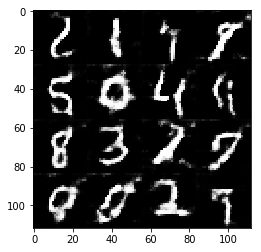

Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 1.1510
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.2108
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.4765... Generator Loss: 0.3690
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.9894... Generator Loss: 0.1973
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 2.2864
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 1.5701
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 1.6617... Generator Loss: 0.2806
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 1.7930
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 0.7625
Epoch 1/2.

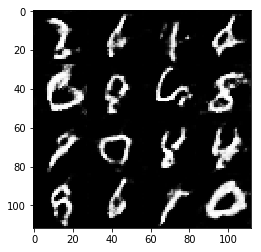

Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.3671
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.7790... Generator Loss: 2.4599
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.6013
Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.3425
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.3428
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 1.2986
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.8635... Generator Loss: 1.6061
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.6703


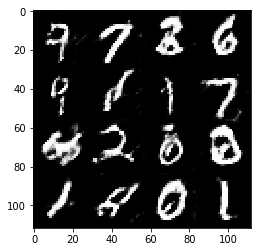

In [13]:
batch_size = 128
z_dim = 300
learning_rate = 0.00072
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.1691... Generator Loss: 3.0643
Epoch 0/1... Discriminator Loss: 0.2953... Generator Loss: 1.8023
Epoch 0/1... Discriminator Loss: 0.6150... Generator Loss: 0.8442
Epoch 0/1... Discriminator Loss: 0.5614... Generator Loss: 1.9004
Epoch 0/1... Discriminator Loss: 1.2006... Generator Loss: 2.1920
Epoch 0/1... Discriminator Loss: 0.3978... Generator Loss: 1.7677
Epoch 0/1... Discriminator Loss: 0.8989... Generator Loss: 0.6347
Epoch 0/1... Discriminator Loss: 2.5497... Generator Loss: 1.1651
Epoch 0/1... Discriminator Loss: 0.4569... Generator Loss: 1.5965
Epoch 0/1... Discriminator Loss: 0.5050... Generator Loss: 3.5158
Epoch 0/1... Discriminator Loss: 3.5419... Generator Loss: 6.7816
Epoch 0/1... Discriminator Loss: 1.1329... Generator Loss: 0.5037
Epoch 0/1... Discriminator Loss: 1.8501... Generator Loss: 0.2679
Epoch 0/1... Discriminator Loss: 1.6200... Generator Loss: 3.3539
Epoch 0/1... Discriminator Loss: 0.7895... Generator Loss: 0.9823
Epoch 0/1.

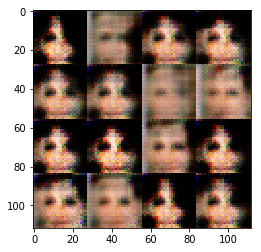

Epoch 0/1... Discriminator Loss: 1.1557... Generator Loss: 1.1567
Epoch 0/1... Discriminator Loss: 3.0497... Generator Loss: 2.9215
Epoch 0/1... Discriminator Loss: 1.3817... Generator Loss: 0.6817
Epoch 0/1... Discriminator Loss: 1.3453... Generator Loss: 0.7012
Epoch 0/1... Discriminator Loss: 1.3309... Generator Loss: 0.7206
Epoch 0/1... Discriminator Loss: 1.2070... Generator Loss: 1.1520
Epoch 0/1... Discriminator Loss: 1.0659... Generator Loss: 1.0813
Epoch 0/1... Discriminator Loss: 1.5773... Generator Loss: 0.3894
Epoch 0/1... Discriminator Loss: 2.1173... Generator Loss: 0.1490
Epoch 0/1... Discriminator Loss: 1.0366... Generator Loss: 1.1005
Epoch 0/1... Discriminator Loss: 1.4258... Generator Loss: 0.9984
Epoch 0/1... Discriminator Loss: 1.3041... Generator Loss: 1.4732
Epoch 0/1... Discriminator Loss: 1.2973... Generator Loss: 0.6848
Epoch 0/1... Discriminator Loss: 1.1735... Generator Loss: 0.8632
Epoch 0/1... Discriminator Loss: 1.5064... Generator Loss: 1.2595
Epoch 0/1.

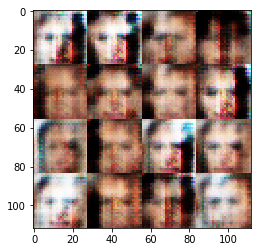

Epoch 0/1... Discriminator Loss: 1.6383... Generator Loss: 0.4580
Epoch 0/1... Discriminator Loss: 1.5020... Generator Loss: 0.5554
Epoch 0/1... Discriminator Loss: 1.4135... Generator Loss: 0.7269
Epoch 0/1... Discriminator Loss: 0.9469... Generator Loss: 1.1150
Epoch 0/1... Discriminator Loss: 1.6106... Generator Loss: 1.6576
Epoch 0/1... Discriminator Loss: 1.3290... Generator Loss: 0.9087
Epoch 0/1... Discriminator Loss: 1.2841... Generator Loss: 0.5297
Epoch 0/1... Discriminator Loss: 1.3692... Generator Loss: 0.6896
Epoch 0/1... Discriminator Loss: 1.3894... Generator Loss: 0.4702
Epoch 0/1... Discriminator Loss: 1.5015... Generator Loss: 1.7254
Epoch 0/1... Discriminator Loss: 1.3115... Generator Loss: 0.5782
Epoch 0/1... Discriminator Loss: 1.6977... Generator Loss: 2.1531
Epoch 0/1... Discriminator Loss: 1.1493... Generator Loss: 0.7152
Epoch 0/1... Discriminator Loss: 1.0923... Generator Loss: 0.9154
Epoch 0/1... Discriminator Loss: 1.8845... Generator Loss: 1.8591
Epoch 0/1.

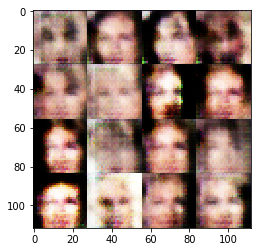

Epoch 0/1... Discriminator Loss: 1.2930... Generator Loss: 0.7454
Epoch 0/1... Discriminator Loss: 1.2390... Generator Loss: 1.0204
Epoch 0/1... Discriminator Loss: 1.2171... Generator Loss: 0.9752
Epoch 0/1... Discriminator Loss: 1.2223... Generator Loss: 1.2311
Epoch 0/1... Discriminator Loss: 2.3514... Generator Loss: 0.1366
Epoch 0/1... Discriminator Loss: 1.2823... Generator Loss: 0.6554
Epoch 0/1... Discriminator Loss: 1.0282... Generator Loss: 0.9081
Epoch 0/1... Discriminator Loss: 1.1923... Generator Loss: 0.6928
Epoch 0/1... Discriminator Loss: 0.9738... Generator Loss: 0.8881
Epoch 0/1... Discriminator Loss: 1.3215... Generator Loss: 0.6708
Epoch 0/1... Discriminator Loss: 1.1518... Generator Loss: 0.6472
Epoch 0/1... Discriminator Loss: 1.1207... Generator Loss: 1.2281
Epoch 0/1... Discriminator Loss: 1.2698... Generator Loss: 0.7168
Epoch 0/1... Discriminator Loss: 1.1532... Generator Loss: 0.6579
Epoch 0/1... Discriminator Loss: 1.3688... Generator Loss: 0.7641
Epoch 0/1.

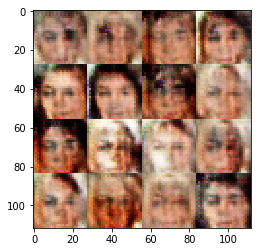

Epoch 0/1... Discriminator Loss: 1.4127... Generator Loss: 0.4876
Epoch 0/1... Discriminator Loss: 1.4929... Generator Loss: 0.6300
Epoch 0/1... Discriminator Loss: 1.1583... Generator Loss: 0.9281
Epoch 0/1... Discriminator Loss: 1.2488... Generator Loss: 0.5394
Epoch 0/1... Discriminator Loss: 0.9959... Generator Loss: 0.9432
Epoch 0/1... Discriminator Loss: 1.1524... Generator Loss: 0.5864
Epoch 0/1... Discriminator Loss: 1.4410... Generator Loss: 0.4148
Epoch 0/1... Discriminator Loss: 1.4948... Generator Loss: 0.3749
Epoch 0/1... Discriminator Loss: 1.3467... Generator Loss: 0.6721
Epoch 0/1... Discriminator Loss: 1.6747... Generator Loss: 0.3016
Epoch 0/1... Discriminator Loss: 1.2316... Generator Loss: 1.2305
Epoch 0/1... Discriminator Loss: 1.7651... Generator Loss: 0.3398
Epoch 0/1... Discriminator Loss: 1.6699... Generator Loss: 1.6127
Epoch 0/1... Discriminator Loss: 1.3719... Generator Loss: 0.6027
Epoch 0/1... Discriminator Loss: 1.2421... Generator Loss: 0.6729
Epoch 0/1.

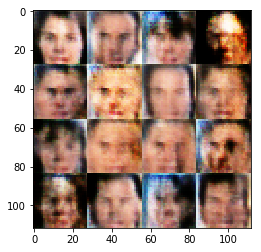

Epoch 0/1... Discriminator Loss: 1.3250... Generator Loss: 0.6252
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.6593
Epoch 0/1... Discriminator Loss: 1.2063... Generator Loss: 0.8849
Epoch 0/1... Discriminator Loss: 1.4475... Generator Loss: 0.4388
Epoch 0/1... Discriminator Loss: 1.4654... Generator Loss: 0.4054
Epoch 0/1... Discriminator Loss: 1.3498... Generator Loss: 0.5944
Epoch 0/1... Discriminator Loss: 1.4923... Generator Loss: 0.5040
Epoch 0/1... Discriminator Loss: 1.5866... Generator Loss: 0.3289
Epoch 0/1... Discriminator Loss: 1.3315... Generator Loss: 0.5696
Epoch 0/1... Discriminator Loss: 1.2143... Generator Loss: 0.8254
Epoch 0/1... Discriminator Loss: 1.5502... Generator Loss: 0.4010
Epoch 0/1... Discriminator Loss: 1.2938... Generator Loss: 1.5587
Epoch 0/1... Discriminator Loss: 1.4904... Generator Loss: 0.4435
Epoch 0/1... Discriminator Loss: 1.5069... Generator Loss: 0.3265
Epoch 0/1... Discriminator Loss: 1.4051... Generator Loss: 0.5541
Epoch 0/1.

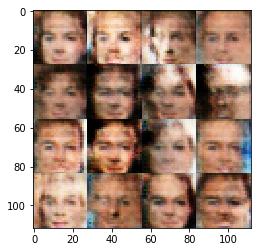

Epoch 0/1... Discriminator Loss: 1.0978... Generator Loss: 0.7453
Epoch 0/1... Discriminator Loss: 1.6234... Generator Loss: 1.8527
Epoch 0/1... Discriminator Loss: 1.3226... Generator Loss: 0.5197
Epoch 0/1... Discriminator Loss: 1.3428... Generator Loss: 1.0356
Epoch 0/1... Discriminator Loss: 1.4683... Generator Loss: 0.4210
Epoch 0/1... Discriminator Loss: 2.0029... Generator Loss: 0.1934
Epoch 0/1... Discriminator Loss: 1.7457... Generator Loss: 0.2606
Epoch 0/1... Discriminator Loss: 1.4711... Generator Loss: 1.0587
Epoch 0/1... Discriminator Loss: 1.3225... Generator Loss: 1.0771
Epoch 0/1... Discriminator Loss: 1.2248... Generator Loss: 0.7440
Epoch 0/1... Discriminator Loss: 1.3423... Generator Loss: 0.6653
Epoch 0/1... Discriminator Loss: 1.9391... Generator Loss: 0.2333
Epoch 0/1... Discriminator Loss: 1.7768... Generator Loss: 1.3169
Epoch 0/1... Discriminator Loss: 1.2546... Generator Loss: 1.5952
Epoch 0/1... Discriminator Loss: 1.1613... Generator Loss: 1.1870
Epoch 0/1.

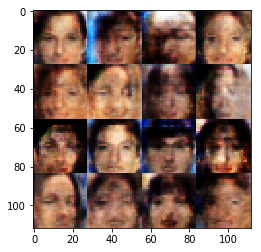

Epoch 0/1... Discriminator Loss: 1.5656... Generator Loss: 1.9078
Epoch 0/1... Discriminator Loss: 1.5134... Generator Loss: 0.3586
Epoch 0/1... Discriminator Loss: 1.1114... Generator Loss: 1.4583
Epoch 0/1... Discriminator Loss: 1.3591... Generator Loss: 0.5254
Epoch 0/1... Discriminator Loss: 1.9148... Generator Loss: 0.2360
Epoch 0/1... Discriminator Loss: 0.8642... Generator Loss: 1.1116
Epoch 0/1... Discriminator Loss: 1.4390... Generator Loss: 0.6897
Epoch 0/1... Discriminator Loss: 1.4335... Generator Loss: 0.4891
Epoch 0/1... Discriminator Loss: 1.3426... Generator Loss: 0.4583
Epoch 0/1... Discriminator Loss: 1.3394... Generator Loss: 0.5306
Epoch 0/1... Discriminator Loss: 1.2135... Generator Loss: 0.9292
Epoch 0/1... Discriminator Loss: 1.2015... Generator Loss: 0.8329
Epoch 0/1... Discriminator Loss: 1.3612... Generator Loss: 0.6565
Epoch 0/1... Discriminator Loss: 1.5641... Generator Loss: 1.5214
Epoch 0/1... Discriminator Loss: 1.1687... Generator Loss: 0.8355
Epoch 0/1.

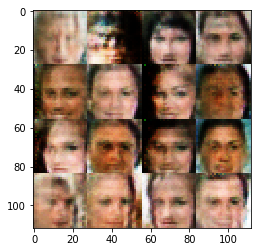

In [14]:
batch_size = 128
z_dim = 600
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.